## Import your stuff

In [1]:
import numpy as np
import pandas as pd
import emcee
from scipy.optimize import minimize
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import matplotlib as mpl
import simulator as faas
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
seed = 1

## Set up the prior

In [2]:
upper = np.array([12,  12,
  12,  12, -2, -2, -2,
 -2])
lower = np.array([6,  6,
  6,  6, -8, -8, -8,
 -8])

prior_mean = np.array([1.1e-03, -3.9e-01])
prior_cov = np.diag(np.array([(0.0011*0.2)**2, (0.39*0.2)**2]))

prior = priors.Gaussian_Unif(prior_mean, prior_cov, lower, upper, 2)

epsilon_mean = np.array([0]*94)
epsilon_cov = np.diag(np.array([0.5] * 94))
epsilon_prior = priors.Gaussian(epsilon_mean, epsilon_cov)

#print(faasSimulator.exp(1))

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [3]:
faasSimulator = faas.faas_Model()

## repeating last fratio for short rows
def simulator(th, seed, simulator_args, batch):
    
    eps_prior = simulator_args[0]
    eps = eps_prior.draw()
    #eps.index = ['epsilon' + str(i) for i in np.arange(0,94)]
    #eps = [0] * 94
    
    
    return faasSimulator.simulation(np.concatenate([th, eps]), seed)

simulator_args = [epsilon_prior]
theta0 = faasSimulator.theta0

theta_f = [8.886491e+00,  7.924279e+00,
   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
  -6.585027e+00,  1.100000e-03, -3.900000e-01]

#th = [9.91142303e+00,  9.99069025e+00,  8.02619461e+00,  7.84794110e+00,
# -7.00810822e+00, -3.99945402e+00, -5.60403475e+00, -3.25229427e+00,
#  8.28864590e-04, -5.00703921e-01]
print(simulator(theta_f, 0, simulator_args, 1))


[ 1.20571688  1.53460257  1.42        2.07239783  2.99487254  1.42
  1.35284146  1.85539869  0.236       1.66792247  2.41212571  1.54
 12.52859714 12.52868415  9.096       9.33774719  9.33793472 11.06
  8.62297111  8.62297127 35.204       7.95275115  7.96187466  2.396
  1.          1.00000002  1.588      12.58221066 12.58223682 11.06
 12.49894946 12.49911089  9.096      11.3311408  11.33157052 35.204
 12.7597674  12.75977217 17.604       1.          1.         39.604
  2.59836955  4.245863    1.276       3.65438397  5.65780212  1.216
  2.83404835  4.59287051  1.264       7.04874076  9.12582223  1.06
  2.59128586  4.2350133   1.276       2.08909546  3.42025749  1.312
  3.5870195   5.57404073  1.216      10.47624802 11.31691463  1.132
 17.24806737 17.24808466  9.096       4.01742745  6.10156602  1.192
  4.14457792  6.36673139  1.3         4.0655928   6.26965593  1.3
  8.65048248 10.70615943  1.168      19.40825111 19.40832873  9.096
 13.91199394 14.19690724  1.468      17.59167264 17.591

In [ ]:
# theta_fiducial = np.array([8.886491e+00,  7.924279e+00,
#   1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
#  -6.585027e+00,  1.100000e-03, -3.900000e-01])
# eta_fiducial = np.array(np.load('epsfid.npy'))

# Cinv = faasSimulator.Cinv
# #np.save('Finv.npy', Finv) # save Finv
# mu = np.load('mu.npy') # save mu
# #np.save('Cinv.npy', Cinv) # save Cinv
# dmudt = np.load('dmudt.npy') # save dmudt


# Compressor = score.Gaussian(len(faasSimulator.data()[0,:]), np.concatenate([theta_fiducial, eta_fiducial]), 
#                             mu = mu, Cinv = Cinv, dmudt = dmudt)

# Compressor.compute_fisher()
# Finv = Compressor.Finv[0:10,0:10]

# nuisance_indices = np.arange(10,104)

# def compressor(d, compressor_args):
#     nuisances_indices = compressor_args[0]
#     return Compressor.projected_scoreMLE(d, nuisance_indices)
# compressor_args = [nuisance_indices]

## Set up the compressor
This must have the signature `compressor(data, args)` -> `np.array([n_summaries])`
In this case we are going to do _nuisance hardened_ Gaussian score compression $$\bar{\mathbf{t}}_\theta = \mathbf{t}_\theta - \mathbf{F}_{\theta\eta}\mathbf{F}^{-1}_{\eta\eta}\mathbf{t}_\eta$$ where $$\mathbf{t}_{(\theta, \eta)} = \nabla_{(\theta, \eta)}^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$
We'll use the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

In [4]:
theta_fiducial = np.array([8.886491e+00,  7.924279e+00,
  1.050515e+01,  7.397940e+00, -3.682371e+00, -4.509306e+00, -6.162727e+00,
 -6.585027e+00,  1.100000e-03, -3.900000e-01])
eta_fiducial = [0.1] * 94
#print(eta_fiducial)
mu = faasSimulator.simulation(np.concatenate([theta_fiducial, eta_fiducial]), seed)
Cinv = faasSimulator.Cinv
print(Cinv.shape)

h = np.array(abs(np.concatenate([theta_fiducial, eta_fiducial])))*0.01
dmudt = faasSimulator.dmudt(np.concatenate([theta_fiducial, eta_fiducial]), h)
print(dmudt.shape)
Compressor = score.Gaussian(len(faasSimulator.data()[0,:]), np.concatenate([theta_fiducial, eta_fiducial]), 
                            mu = mu, Cinv = Cinv, dmudt = dmudt)

Compressor.compute_fisher()
Finv = Compressor.Finv[0:10,0:10]

nuisance_indices = np.arange(10,104)

def compressor(d, compressor_args):
    nuisances_indices = compressor_args[0]
    return Compressor.projected_scoreMLE(d, nuisance_indices)
compressor_args = [nuisance_indices]

(282, 282)
(104, 282)


## Load in the compressed data

In [5]:
compressed_data = compressor(faasSimulator.data_comp(), compressor_args)
print(compressed_data)
n_data = len(compressed_data)

[ 8.84693319e+00  7.87193946e+00  1.04668244e+01  7.60554193e+00
 -3.66810304e+00 -4.46340453e+00 -6.15641698e+00 -6.59143228e+00
  1.09671346e-03 -3.88028524e-01]


## Load in data

## Save FINV, only worth doing once, make sure to load

In [ ]:
# np.save('Finv.npy', Finv) # save Finv
# np.save('mu.npy', mu) # save mu
# #np.save('Cinv.npy', Cinv) # save Cinv
# np.save('dmudt.npy', dmudt) # save dmudt

In [ ]:
# data = faasSimulator.data()[0]

## Define ensemble of NDEs

In [6]:
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=10, n_data=n_data, n_hiddens=[50,50], n_mades=8, act_fun=tf.tanh, index=0),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=10, n_data=n_data, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Create DELFI object

In [7]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, Finv = None, theta_fiducial = theta_fiducial,
                       param_limits = [np.concatenate((lower, [(0.0011-(0.0011*0.8)**2),(-0.39-(0.39*0.8)**2)])), np.concatenate((upper, [(0.0011+(0.0011*0.8)**2),(-0.39+(0.39*0.8)**2)]))],
                       param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
                       results_dir = "results/",input_normalization = None, restore = True, save = True, nwalkers = 1000)

In [ ]:
# DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs,
#                        param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0'],
#                        results_dir = "results_batch_whole_comp/", restore = False, save = True)

## Fisher pre-training to initialize the NDEs

In [ ]:
DelfiEnsemble.fisher_pretraining(plot=False)

## Sequential Neural Likelihood

/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/postFLASH.py:114: RuntimeWarning: overflow encountered in multiply
  F_ratio_course = (post_out[relevantID, 7] + float(F_ratio)*post_out[relevantID, 8])/(pre_out["OGB5N"] + float(F_ratio)*pre_out["CaOGB5N"])
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/postFLASH.py:114: RuntimeWarning: overflow encountered in true_divide
  F_ratio_course = (post_out[relevantID, 7] + float(F_ratio)*p

Simulator returns NaN/inf for parameter values: [ 6.00577879e+00  1.05201703e+01  9.45071463e+00  6.87740946e+00
 -2.58940819e+00 -4.43547860e+00 -6.32201844e+00 -6.49935250e+00
  1.07013496e-03 -4.32744561e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/postFLASH.py:114: RuntimeWarning: overflow encountered in true_divide
  F_ratio_course = (post_out[relevantID, 7] + float(F_ratio)*post_out[relevantID, 8])/(pre_out["OGB5N"] + float(F_ratio)*pre_out["CaOGB5N"])
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Simulator returns NaN/inf for parameter values: [ 9.18504320e+00  6.85316704e+00  1.05307402e+01  1.19965925e+01
 -4.43709776e+00 -4.57564924e+00 -7.79003058e+00 -7.92310460e+00
  9.38988276e-04 -3.62111829e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/postFLASH.py:114: RuntimeWarning: overflow encountered in true_divide
  F_ratio_course = (post_out[relevantID, 7] + float(F_ratio)*p

Simulator returns NaN/inf for parameter values: [ 7.79128309e+00  8.22667589e+00  1.14480832e+01  6.50795287e+00
 -5.47803926e+00 -6.01213349e+00 -7.81918884e+00 -3.28369542e+00
  7.65852876e-04 -3.02327065e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Population 1/39
Sampling proposal density...
Done.


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Simulator returns NaN/inf for parameter values: [ 1.05468841e+01  6.32320036e+00  8.91053117e+00  6.82485242e+00
 -5.90357942e+00 -5.23609201e+00 -4.41385245e+00 -6.65818711e+00
  9.20693391e-04 -4.28272536e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Simulator returns NaN/inf for parameter values: [ 1.06653561e+01  6.17866015e+00  8.92321233e+00  6.83232253e+00
 -6.19247392e+00 -5.16526347e+00 -4.27121458e+00 -6.54788138e+00
  9.14534787e-04 -4.28898599e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

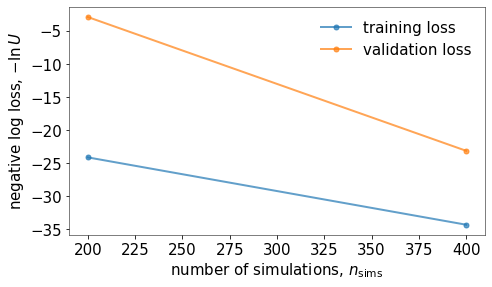

Population 2/39
Sampling proposal density...
Done.


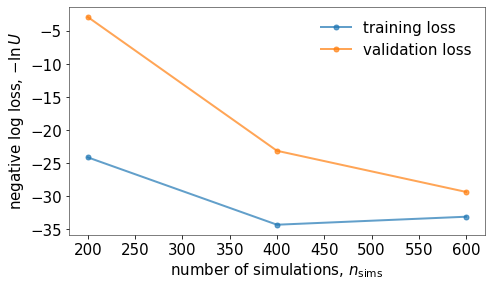

Population 3/39
Sampling proposal density...
Done.


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/postFLASH.py:114: RuntimeWarning: overflow encountered in true_divide
  F_ratio_course = (post_out[relevantID, 7] + float(F_ratio)*post_out[relevantID, 8])/(pre_out["OGB5N"] + float(F_ratio)*pre_out["CaOGB5N"])
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 

Simulator returns NaN/inf for parameter values: [ 9.55005114e+00  9.08793059e+00  8.85287260e+00  8.06922303e+00
 -2.87685343e+00 -7.23439959e+00 -6.23365139e+00 -6.80445747e+00
  1.11275864e-03 -3.21528956e-01] (rank 0)


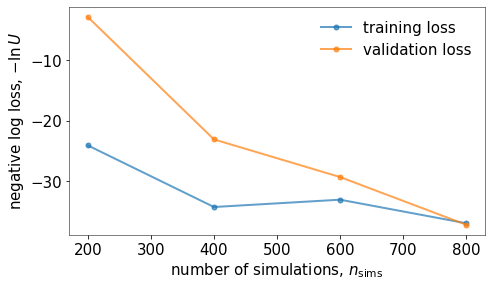

Population 4/39
Sampling proposal density...
Done.


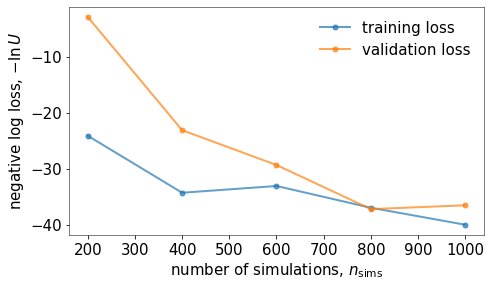

Population 5/39
Sampling proposal density...
Done.


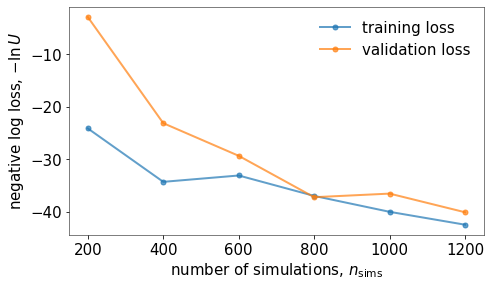

Population 6/39
Sampling proposal density...
Done.


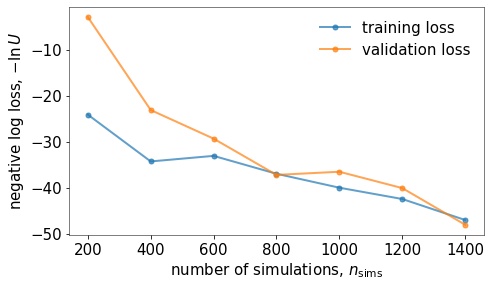

Population 7/39
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/postFLASH.py:114: RuntimeWarning: overflow encountered in true_divide
  F_ratio_course = (post_out[relevantID, 7] + float(F_ratio)*post_out[relevantID, 8])/(pre_out["OGB5N"] + float(F_ratio)*pre_out["CaOGB5N"])


Simulator returns NaN/inf for parameter values: [ 9.93600838e+00  9.49513500e+00  8.52951289e+00  7.79768986e+00
 -4.45265954e+00 -7.65080061e+00 -6.47602128e+00 -7.31275073e+00
  1.22014133e-03 -3.64640856e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Simulator returns NaN/inf for parameter values: [ 9.93600838e+00  9.49513500e+00  8.52951289e+00  7.79768986e+00
 -4.45265954e+00 -7.65080061e+00 -6.47602128e+00 -7.31275073e+00
  1.22014133e-03 -3.64640856e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 t

Simulator returns NaN/inf for parameter values: [ 9.93600838e+00  9.49513500e+00  8.52951289e+00  7.79768986e+00
 -4.45265954e+00 -7.65080061e+00 -6.47602128e+00 -7.31275073e+00
  1.22014133e-03 -3.64640856e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/Thesis/pydelfi/examples/simulators/faas_python3/postFLASH.py:114: RuntimeWarning: overflow encountered in multiply
  F_ratio_course = (post_out[relevantID, 7] + float(F_ratio)*post

Simulator returns NaN/inf for parameter values: [ 9.96385085e+00  1.00099821e+01  8.05323479e+00  8.29849803e+00
 -4.70760719e+00 -7.42249470e+00 -6.12029626e+00 -6.81332266e+00
  1.19136909e-03 -3.91965497e-01] (rank 0)


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


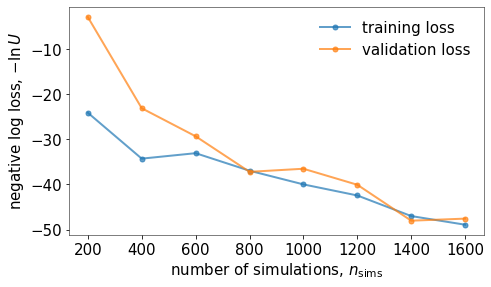

Population 8/39
Sampling proposal density...
Done.


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


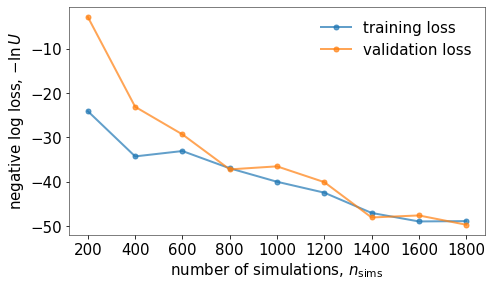

Population 9/39
Sampling proposal density...


/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Done.


Exception in thread Thread-5756:
Traceback (most recent call last):
  File "/home/thomas/anaconda3/envs/thesis/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/thomas/anaconda3/envs/thesis/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/multiprocess/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/multiprocess/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/multiprocess/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/multiprocess/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/home/thomas/anaconda3/envs/thesis/lib/python3.6/site-packages/multiprocess/context

In [ ]:
n_initial = 200
n_batch = 200
n_populations = 39

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=50., save_intermediate_posteriors=False, simulator_args = simulator_args, compressor_args = compressor_args)

## Sample the learned posterior

In [ ]:
from emcee.autocorr import integrated_time
#from emcee.moves import StretchMove

def emcee_sample(log_likelihood=None, x0=None, burn_in_chain=10, main_chain=10, nwalkers= 2000):

        # Set the log likelihood (default to the posterior if none given)
        if log_likelihood is None:
            log_likelihood = lambda x: DelfiEnsemble.log_posterior_stacked(x, DelfiEnsemble.data)[0]

        # Set up default x0
        if x0 is None:
            #x0 = emcee.utils.sample_ball(theta_fiducial, [0.01]*8 + [0.001] + [0.01], nwalkers)
            x0 = [DelfiEnsemble.posterior_samples[-i,:] for i in range(nwalkers)]

        # Set up the sampler
        sampler = emcee.EnsembleSampler(nwalkers, 10, log_likelihood)

        # Burn-in chain
        pos, prob, state = sampler.run_mcmc(x0, burn_in_chain)
        sampler.reset()

        sampler.run_mcmc(pos, main_chain)
        #print(sampler.acceptance_fraction)
        return sampler.flatchain


    

posterior_samples = emcee_sample(burn_in_chain=1000, main_chain=3000)

# acls = []
# for samps in posterior_samples:
#     acls.append(integrated_time(samps))
#     posterior_samples = posterior_samples[0:-1:int(np.max(acls)),:]

    
print(posterior_samples)
post = np.unique(posterior_samples, axis=0)
np.save('pst_samples.npy', post) # save

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:

posterior_samples = np.load('pst_samples_whole_comp_fisher_pre.npy')
pst = np.unique(posterior_samples, axis=0)
print(pst.shape)
print(pst)
print(posterior_samples.shape)
triangle_plot(samples=[post], savefig=True, filename='whole_comp_pre.pdf')

# param_names = ['logKonTN', 'logKonTC', 'logKonRN', 'logKonRC', 'logKDTN', 'logKDTC', 'logKDRN', 'logKDRC', 'malpha', 'alpha0']
# from IPython.display import display, Math
# params_med = []
# params_up = []
# params_low = []
# for i in range(10):
#     mcmc = np.percentile(posterior_samples[:, i], [16, 50, 84])
#     q = np.diff(mcmc)
#     txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
#     txt = txt.format(mcmc[1], q[0], q[1], param_names[i])
#     params_low.append(mcmc[1] - q[0])
#     params_med.append(mcmc[1])
#     params_up.append(mcmc[1] + q[1])
#     print(txt)


# plt.show()
# print(params_med)

## Plot learned log-likelihood vs squared error (proportional to Gaussian Likelihood)


In [ ]:
# post = np.load('pst_samples_whole_comp_fisher.npy')
# post = np.unique(post, axis=0)
# eps = [0]*94
# ll = lambda x: np.sum(np.sum((faasSimulator.data() - faasSimulator.forward(np.concatenate((x,eps)), seed))**2))

# ll_post = lambda x: DelfiEnsemble.log_likelihood_stacked(x, DelfiEnsemble.data)[0]

# # # pt_ll = [ll(i) for i in post]
# pt_ll_post = [ll_post(i) for i in post]
# #print(post.shape)
x = np.loadtxt(open('def.csv', "rb"), delimiter=',').T

plt.scatter(x[0], x[1])
plt.plot(np.unique(x[0]), np.poly1d(np.polyfit(x[0], x[1], 1))(np.unique(x[0])), color='red')
plt.xlabel("NDE log likelihood")
plt.ylabel("Squared Error")
plt.tight_layout()
plt.savefig('postvssquared_500.pdf')
plt.show()